# Bike Sharing Rebalancing Problem

The following implementation is derivated from the following paper: https://www.sciencedirect.com/science/article/abs/pii/S0305048313001187


## Introduction

| Variable Name  | Description |
| ------------- | ------------- |
| <i>V</i>   | Set of vertices |
| <i>A</i>   | Set of arcs  |
| <i>n</i>   | Number of stations |
| <i>m</i>   |  Number of vehicles  |
| <i>Q</i>   | Vehicle capacity |
| <i>q<sub>i</sub></i>  |  Demand at vertex i  |
| <i>c<sub>ij</sub></i>  |  Cost of arc (i,j)  |

In [79]:
#Importing cplex API
import sys
import docplex.cp

#Importing numpy and random generator
import numpy as np
rand = np.random

#Importing pyplot
import matplotlib.pyplot as plt

#Importing docplex model
from docplex.mp.model import Model
import itertools

In [80]:
#Initial values
n = 6                                      # amount of stations (Reggio-Emilia)
m = 2                                            # amount of vehicles
Q = 10                                           # vehicles capacity
end = n + 1
Vo = [i for i in range(1, n+1)] # stations without starting and ending deposit   
V = [0] + Vo + [end] 
#A = [(i, j) for i in V for j in V]           # edges A_tilde
A_tilde = [(i, j) for i in V for j in V]  
q = {i: rand.randint(-Q, Q) for i in V}           # demand along edges
#q[0] = 0
q[n+1] = 0
Qtot = sum(q.values()) - q[0] - q[n+1]
A_tilde

[(0, 0),
 (0, 1),
 (0, 2),
 (0, 3),
 (0, 4),
 (0, 5),
 (0, 6),
 (0, 7),
 (1, 0),
 (1, 1),
 (1, 2),
 (1, 3),
 (1, 4),
 (1, 5),
 (1, 6),
 (1, 7),
 (2, 0),
 (2, 1),
 (2, 2),
 (2, 3),
 (2, 4),
 (2, 5),
 (2, 6),
 (2, 7),
 (3, 0),
 (3, 1),
 (3, 2),
 (3, 3),
 (3, 4),
 (3, 5),
 (3, 6),
 (3, 7),
 (4, 0),
 (4, 1),
 (4, 2),
 (4, 3),
 (4, 4),
 (4, 5),
 (4, 6),
 (4, 7),
 (5, 0),
 (5, 1),
 (5, 2),
 (5, 3),
 (5, 4),
 (5, 5),
 (5, 6),
 (5, 7),
 (6, 0),
 (6, 1),
 (6, 2),
 (6, 3),
 (6, 4),
 (6, 5),
 (6, 6),
 (6, 7),
 (7, 0),
 (7, 1),
 (7, 2),
 (7, 3),
 (7, 4),
 (7, 5),
 (7, 6),
 (7, 7)]

In [81]:
# Generating random coordinates and computing the distances using euclidian distance
coord = rand.rand(len(V), 2) * 500
c = {(i, j): 
        float('Inf') if i == n+1 else np.hypot(coord[i][0]-coord[j][0], coord[i][1]-coord[j][1]) 
             for i, j in A_tilde}       
for i in c.keys():
    if i[0] == 0 and i[1] == n+1:
        c[i] = 0.0
    elif i[1] == n+1:
        c[i] = c[i[0], 0]
for i in c.keys():
    if i[1] == 0:
        c[i] = float('inf')
c

{(0, 0): inf,
 (0, 1): 250.1520815105528,
 (0, 2): 287.8641390358233,
 (0, 3): 386.06950688280597,
 (0, 4): 139.42886649630734,
 (0, 5): 447.0344714089012,
 (0, 6): 415.39561589434703,
 (0, 7): 0.0,
 (1, 0): inf,
 (1, 1): 0.0,
 (1, 2): 117.4092808765955,
 (1, 3): 158.9295622730866,
 (1, 4): 292.87547446970285,
 (1, 5): 214.92827403897562,
 (1, 6): 401.9879810473423,
 (1, 7): 250.1520815105528,
 (2, 0): inf,
 (2, 1): 117.4092808765955,
 (2, 2): 0.0,
 (2, 3): 243.9932327862977,
 (2, 4): 372.49560301008523,
 (2, 5): 286.20915964345085,
 (2, 6): 518.3949716524484,
 (2, 7): 287.8641390358233,
 (3, 0): inf,
 (3, 1): 158.9295622730866,
 (3, 2): 243.9932327862977,
 (3, 3): 0.0,
 (3, 4): 381.89730707275834,
 (3, 5): 61.041009700826905,
 (3, 6): 365.0828676850085,
 (3, 7): 386.06950688280597,
 (4, 0): inf,
 (4, 1): 292.87547446970285,
 (4, 2): 372.49560301008523,
 (4, 3): 381.89730707275834,
 (4, 4): 0.0,
 (4, 5): 440.40222725575615,
 (4, 6): 293.2878516116278,
 (4, 7): 139.42886649630734,
 (5, 

(-5.620465289685466,
 500.0357194535494,
 -0.06144071048925426,
 453.4779695110639)

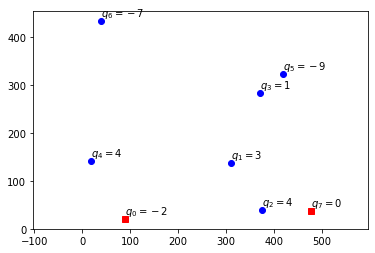

In [82]:
for point in coord[1:]:   
    plt.scatter(point[0], point[1], c='b')

for i in V:
    plt.annotate('$q_%d=%d$' % (i, q[i]), (coord[i][0], coord[i][1]+10))

plt.plot(coord[0][0], coord[0][1], c='r', marker='s') #marker=(5, 1)
plt.plot(coord[end][0], coord[end][1], c='r', marker='s') 
plt.axis('equal')

In [83]:
# Model
f4 = Model('Formulation-F4')

# Decision variables
x = f4.binary_var_dict(A_tilde, name='x')
f = f4.continuous_var_dict(A_tilde, name='f')
g = f4.continuous_var_dict(A_tilde, name='g')

In [84]:
#Function to minimize
f4.minimize(f4.sum(c[i, j]*x[i, j] for i in V for j in V))

#Constraints
f4.add_constraints(f4.sum(x[i, j] for i in V) == 1 for j in Vo) #17
f4.add_constraints(f4.sum(x[j, i] for i in V) == 1 for j in Vo) #18
f4.add_constraint(f4.sum(x[0, j] for j in V) <= m ) #19
f4.add_constraint(f4.sum(x[0, j] for j in Vo) == f4.sum(x[i, n-1] for i in Vo)) #20

for i in range(1, len(Vo) + 1):
    for S in itertools.permutations(Vo, i):
        f4.add_constraint(f4.sum(x[i, j] for j in S for i in S) <= len(S)-1) # 21
        
f4.add_constraints((f[i,j] + g[j,i]) == Q * x[i,j] for i in V for j in V)       #22
f4.add_constraints((f4.sum((f[j, i] - g[i,j]) for i in V) - f4.sum((f[i, j] - g[j,i]) for i in V)) == 2*q[j] for j in Vo) #23
f4.add_constraint(f4.sum(f[0,j] for j in Vo) >= f4.max(0, -Qtot)) #24
f4.add_constraint(f4.sum(f[j,end] for j in Vo) >= f4.max(0, Qtot)) #25
f4.add_constraint((f4.sum(g[j,0] for j in Vo) <= min(m*Q, m*Q + Qtot)))                   #26

f4.add_constraints((max(0,q[i],-q[j]) * x[i,j]) <= f[i,j] for i in V for j in V)                   #27_1
f4.add_constraints(f[i,j] <= (min(Q,Q + q[i],Q -q[j]) * x[i,j])  for i in V for j in V)                   #27_2

f4.add_constraints(((Q - min(Q, Q + q[i], Q - q[j])) * x[i,j]) <= g[j,i] for i in V for j in V)                 #28_1
f4.add_constraints((g[j,i] <= (Q - max(0, q[i], -q[j])) * x[i,j]) for i in V for j in V)                   #28_2


solutionF4 = f4.solve(log_output=True)
f4.solve(log_output=True)


Version identifier: 12.10.0.0 | 2019-11-26 | 843d4de2ae
CPXPARAM_Read_DataCheck                          1
CPXPARAM_RandomSeed                              201903125
Tried aggregator 5 times.
MIP Presolve eliminated 2081 rows and 38 columns.
MIP Presolve modified 186 coefficients.
Aggregator did 54 substitutions.
Reduced MIP has 164 rows, 100 columns, and 819 nonzeros.
Reduced MIP has 38 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.03 sec. (13.62 ticks)
Found incumbent of value 7.0000000e+20 after 0.03 sec. (14.78 ticks)
Probing time = 0.00 sec. (0.24 ticks)
Tried aggregator 1 time.
Detecting symmetries...
Reduced MIP has 164 rows, 100 columns, and 819 nonzeros.
Reduced MIP has 38 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.01 sec. (0.68 ticks)
Probing time = 0.00 sec. (0.24 ticks)
Clique table members: 33.
MIP emphasis: balance optimality and feasibility.
MIP search method: dynamic search.
Parallel mode: deterministic, using up to 8 threads.


docplex.mp.solution.SolveSolution(obj=2051.24,values={x_0_1:1,x_1_6:1,x_..

In [85]:
print(solutionF4)


solution for: Formulation-F4
objective: 0
x_0_1=1
x_1_6=1
x_2_5=1
x_3_7=1
x_4_2=1
x_5_3=1
x_6_4=1
f_0_1=5.000
f_1_6=8.000
f_2_5=9.000
f_3_7=1.000
f_4_2=5.000
f_6_4=1.000
g_1_0=5.000
g_2_4=5.000
g_3_5=10.000
g_4_6=9.000
g_5_2=1.000
g_6_1=2.000
g_7_3=9.000



In [86]:
print(solutionF4.solve_details)


status  = integer optimal solution
time    = 0.094 s.
problem = MILP
gap     = 0%



[(0, 1), (1, 6), (2, 5), (3, 7), (4, 2), (5, 3), (6, 4)]

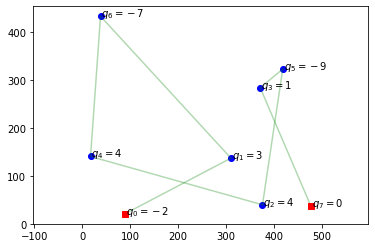

[(0, 1), (1, 6), (2, 5), (3, 7), (4, 2), (5, 3), (6, 4)]

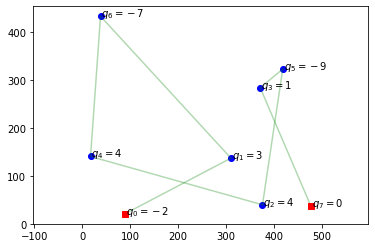

In [88]:
active_arcs = [a for a in A_tilde if x[a].solution_value > 0.9]

for point in coord[1:]:   
    plt.scatter(point[0], point[1], c='b')
    
for i in V:
    plt.annotate('$q_%d=%d$' % (i, q[i]), (coord[i][0]+2, coord[i][1]))
    
for i, j in active_arcs:
    plt.plot([coord[i][0], coord[j][0]], [coord[i][1], coord[j][1]], c='g', alpha=0.3)
    
plt.plot(coord[0][0], coord[0][1], c='r', marker='s') # Starting depot
plt.plot(coord[n+1][0], coord[n+1][1], c='r', marker='s') # Ending depot
plt.axis('equal')

active_arcs